In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
# IBMQ.save_account('')

configrc.store_credentials:WARNING:2022-12-14 04:33:15,603: Credentials already present. Set overwrite=True to overwrite.


In [2]:
from qiskit.providers.fake_provider import FakeVigo
from qiskit import QuantumRegister, ClassicalRegister

In [3]:
backend = Aer.get_backend("aer_simulator")
backend_device = FakeVigo()

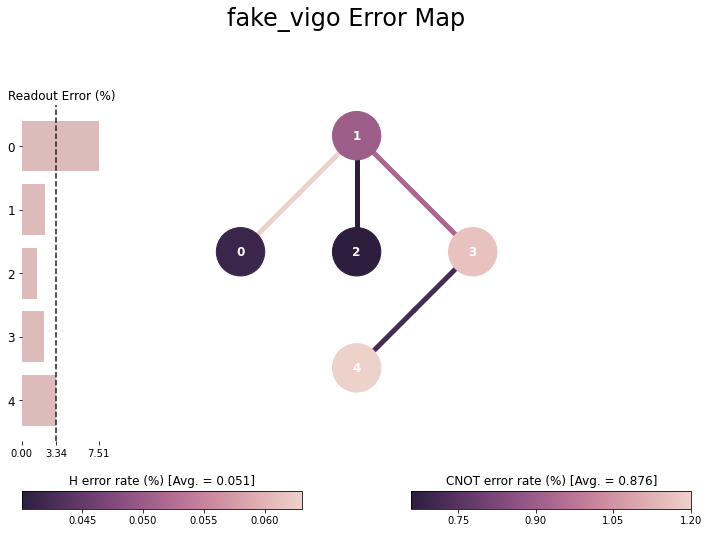

In [7]:
plot_error_map(backend_device)

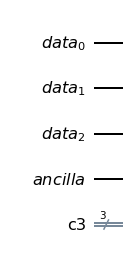

In [38]:
qr = QuantumRegister(3, "data")
ar = QuantumRegister(1, "ancilla")
cr = ClassicalRegister(3)

qc = QuantumCircuit(qr, ar, cr)
qc.draw()

We want ancilla to be -|1>

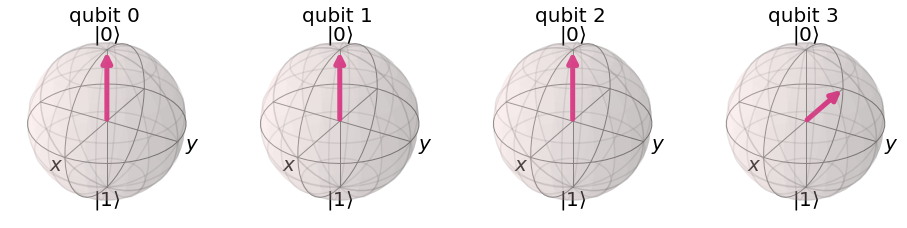

In [39]:
qc.x(ar[0])
qc.h(ar[0])
plot_bloch_multivector(qc)

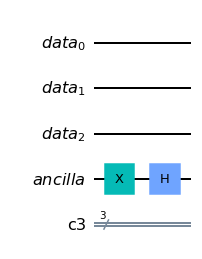

In [40]:
qc.draw()

In [41]:
qc.barrier()

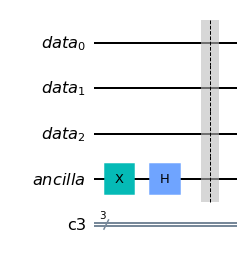

In [42]:
qc.draw()

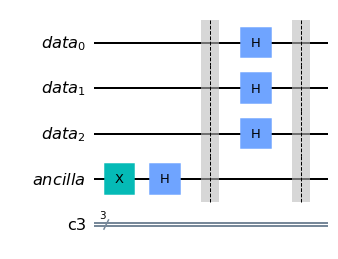

In [43]:
n = 3
for i in range(3):
    qc.h(qr[i])
qc.barrier()
qc.draw()

In [44]:
qc.cx(qr[0], ar[0])
qc.cx(qr[1], ar[0])


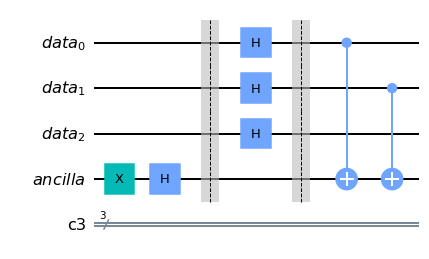

In [45]:
qc.draw()

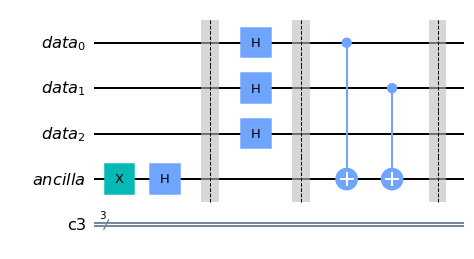

In [46]:
qc.barrier()
qc.draw()

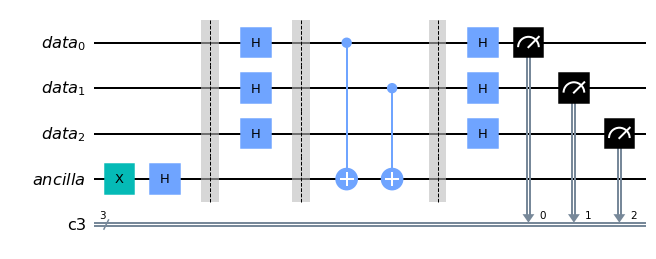

In [47]:
for i in range(3):
    qc.h(qr[i])
    
# for i in range(n):
#     qc.measure(qr[i], cr[i])
qc.measure(qr,cr)
qc.draw()

In [4]:
from qiskit import execute

In [5]:
backend = Aer.get_backend('aer_simulator') # we choose the simulator as our backend
# counts = execute(qc, backend, shots = 1000).result().get_counts() # we run the simulation and get the counts
# plot_histogram(counts) # let us plot a histogram to see the possible outcomes and corresponding probabilities

In [53]:
results = backend.run(qc, shots = 1024).result()
count = results.get_counts()
count

{'011': 1024}

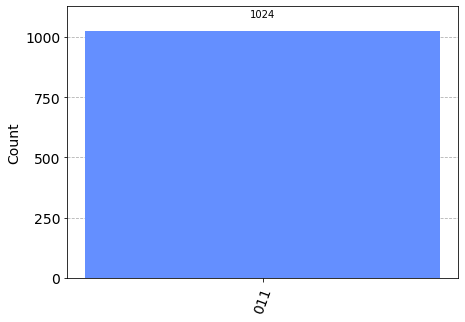

In [54]:
plot_histogram(count)

{'101': 1, '001': 28, '010': 70, '000': 5, '111': 5, '011': 915}


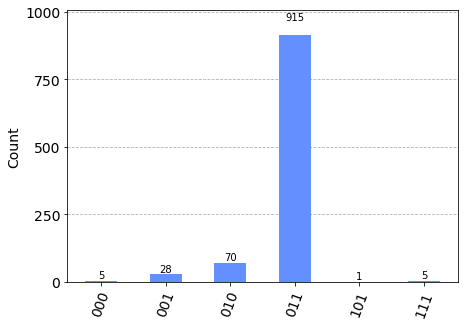

In [63]:
result = backend_device.run(qc, shot=1024).result()
count = result.get_counts()
print(count)
plot_histogram(count)

VQE Basics

In [6]:
import qiskit as qt
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit.opflow import PauliExpectation, CircuitSampler, StateFn, AerPauliExpectation, CircuitStateFn, CircuitOp, MatrixExpectation
from qiskit_nature.circuit.library import HartreeFock
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter
import matplotlib.pyplot as plt

Creating a function that would measure the expectation $<\Psi|\hat{O}|\Psi>$

In [7]:
def expectation(operator, state):
    backend_i = Aer.get_backend('statevector_simulator')
    psi = CircuitStateFn(state)
    measurable_expression = StateFn(operator, is_measurement=True).compose(psi)
    expectation_i = PauliExpectation().convert(measurable_expression)
    sampler = CircuitSampler(backend_i).convert(expectation_i)
    electronic_energy = np.real(sampler.eval())
    return electronic_energy

Obtaining the molecular Hamiltonian in second quantised notation using PySCF Driver

In [4]:
coord = 'H 0.0 0.0 0.0; H 0.0 0.0 0.735' # <atom1> x y z; <atom2> x y z 
driver = PySCFDriver(atom=coord, charge=0, spin=0, basis='sto3g')
es_problem = ElectronicStructureProblem(driver)
second_q_op = es_problem.second_q_ops()

In [75]:
print(second_q_op)
for i in second_q_op:
    print(i)


{'ParticleNumber': FermionicOp([('+_0 -_0', (1+0j)), ('+_1 -_1', (1+0j)), ('+_2 -_2', (1+0j)), ('+_3 -_3', (1+0j))], register_length=4, display_format='sparse'), 'ElectronicEnergy': FermionicOp([('+_0 -_0', -1.2563390730032498), ('+_1 -_1', -0.47189600728114245), ('+_2 -_2', -1.2563390730032498), ('+_3 -_3', -0.47189600728114245), ('+_0 +_0 -_0 -_0', -0.33785507740175813), ('+_0 +_1 -_1...)], register_length=4, display_format='sparse'), 'DipoleMomentX': FermionicOp([('', 0j)], register_length=4, display_format='sparse'), 'DipoleMomentY': FermionicOp([('', 0j)], register_length=4, display_format='sparse'), 'DipoleMomentZ': FermionicOp([('+_0 -_0', 0.6944743507776598), ('+_0 -_1', -0.927833470459232), ('+_1 -_0', -0.9278334704592321), ('+_1 -_1', 0.6944743507776604), ('+_2 -_2', 0.6944743507776598), ('+_2 -_3', -0.9278334704592...)], register_length=4, display_format='sparse'), 'AngularMomentum': FermionicOp([('+_0 -_0', (0.75+0j)), ('+_1 -_1', (0.75+0j)), ('+_2 -_2', (0.75+0j)), ('+_3 -

Converting the Hamiltonian in terms of Pauli Gates using Jordan-Wigner Mapping

In [5]:
mapper = JordanWignerMapper()
converter = QubitConverter(mapper=mapper, two_qubit_reduction=False)
qubit_op = converter.convert(second_q_op['ElectronicEnergy'])

Obtaining some properties of the molecule such as number of electrons, number of spin-orbitals in a given basis

In [7]:
es_particle_number = es_problem.grouped_property_transformed.get_property('ParticleNumber')
num_particles = (es_particle_number.num_alpha, es_particle_number.num_beta)
num_spin_orbitals = es_particle_number.num_spin_orbitals
es_energy = es_problem.grouped_property_transformed.get_property('ElectronicEnergy')
nuclear_repulsion_energy = es_energy.nuclear_repulsion_energy
print('Number Of Particles: ', num_particles)
print('Number of Spin Orbitals: ', num_spin_orbitals)
print('Nuclear Repulsion Energy: ', nuclear_repulsion_energy)

Number Of Particles:  (1, 1)
Number of Spin Orbitals:  4
Nuclear Repulsion Energy:  0.7199689944489797


Generating The Hartree Fock state $|\Phi_o>$

In [14]:
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)

In [15]:
print(init_state)

     ┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘
q_3: ─────
          


Obtaining the Hartree Fock energy SCF energy $<\Phi_o|\hat{H}|\Phi_o>$

In [16]:
electronic_energy = expectation(qubit_op, init_state)
total_energy = electronic_energy+nuclear_repulsion_energy
print(total_energy)

-1.1169989967540035


[0.16417501206169582, -0.7724453373055735, -1.0381858525895313, -1.1116814458426876, -1.1122498261760878, -1.0830044672788772, -1.041371411347063, -0.9950133341668848, -0.9480730476949573, -0.9030487547796899, -0.8613667447573499, -0.8237325736561798, -0.7903836159824098, -0.7612512374273157, -0.7360723206828321, -0.7144778471989196, -0.6960618497455375, -0.6804259382053257, -0.6672002094884821, -0.656048251145591]


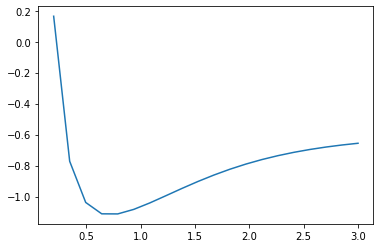

In [10]:
h = np.linspace(0.2, 3, 20)
energy = []
# driver = PySCFDriver(atom=coord, charge=0, spin=0, basis='sto3g')
for i in h:
    # coord = "H 0.0 0.0 0.0; H 0.0 0.0 "+str(i) # <atom1> x y z; <atom2> x y z 
    coord = f"H 0.0 0.0 0.0; H 0.0 0.0 {i}" # <atom1> x y z; <atom2> x y z 
    driver = PySCFDriver(atom=coord, charge=0, spin=0, basis='sto3g')
    es_problem = ElectronicStructureProblem(driver)
    
    second_q_op = es_problem.second_q_ops()
    mapper = JordanWignerMapper()
    converter = QubitConverter(mapper=mapper, two_qubit_reduction=False)
    qubit_op = converter.convert(second_q_op['ElectronicEnergy'])
    
    es_particle_number = es_problem.grouped_property_transformed.get_property('ParticleNumber')
    num_particles = (es_particle_number.num_alpha, es_particle_number.num_beta)
    num_spin_orbitals = es_particle_number.num_spin_orbitals
    es_energy = es_problem.grouped_property_transformed.get_property('ElectronicEnergy')
    nuclear_repulsion_energy = es_energy.nuclear_repulsion_energy
    
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    
    electronic_energy = expectation(qubit_op, init_state)
    total_energy = electronic_energy+nuclear_repulsion_energy
    energy.append(total_energy)

print(energy)
plt.plot(h, energy)

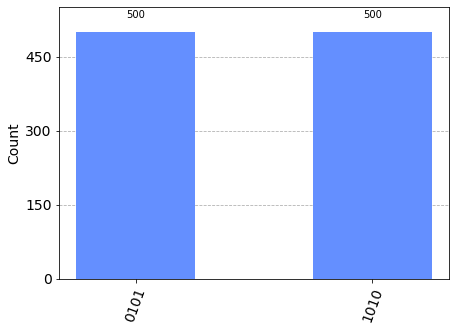

In [26]:
# def making_req_state():
qc = qt.QuantumCircuit(4)
qc.x(0)
qc.x(2)
qc.h(1)
qc.cx(1,3)
qc.cx(3,2)
qc.cx(1, 0)
qc.draw()
qc.measure_all()

backend = Aer.get_backend('qasm_simulator') # we choose the simulator as our backend
counts = execute(qc, backend, shots = 1000).result().get_counts() # we run the simulation and get the counts
plot_histogram(counts) # let us plot a histogram to see the possible outcomes and corresponding probabilities

# return qc
    

In [18]:
def making_req_state():
    qc = qt.QuantumCircuit(4)
    qc.x(0)
    qc.x(2)
    qc.h(1)
    qc.cx(1,3)
    qc.cx(3,2)
    qc.cx(1, 0)
    return qc

[2.1831247777249247, 0.8912010702624085, 0.306899552578194, -0.013223149518348798, -0.1966414035037206, -0.3033569388498011, -0.3656788491509321, -0.4006866292442573, -0.4179284084996091, -0.42347167287413046, -0.4214853067948426, -0.4148654098195774, -0.4055930595849791, -0.39499405781469965, -0.3839320554570222, -0.37294954208078046, -0.3623696366917438, -0.35236875100107024, -0.3430275731404597, -0.334366186241396]


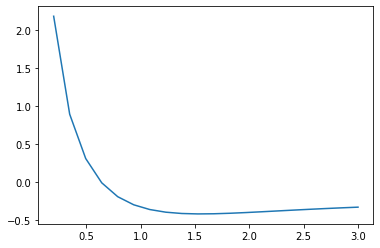

In [19]:
h = np.linspace(0.2, 3, 20)
energy = []
# driver = PySCFDriver(atom=coord, charge=0, spin=0, basis='sto3g')
init_state = making_req_state()

for i in h:
    # coord = "H 0.0 0.0 0.0; H 0.0 0.0 "+str(i) # <atom1> x y z; <atom2> x y z 
    coord = f"H 0.0 0.0 0.0; H 0.0 0.0 {i}" # <atom1> x y z; <atom2> x y z 
    driver = PySCFDriver(atom=coord, charge=0, spin=0, basis='sto3g')
    es_problem = ElectronicStructureProblem(driver)
    
    second_q_op = es_problem.second_q_ops()
    mapper = JordanWignerMapper()
    converter = QubitConverter(mapper=mapper, two_qubit_reduction=False)
    qubit_op = converter.convert(second_q_op['ElectronicEnergy'])
    
    es_particle_number = es_problem.grouped_property_transformed.get_property('ParticleNumber')
    num_particles = (es_particle_number.num_alpha, es_particle_number.num_beta)
    num_spin_orbitals = es_particle_number.num_spin_orbitals
    es_energy = es_problem.grouped_property_transformed.get_property('ElectronicEnergy')
    nuclear_repulsion_energy = es_energy.nuclear_repulsion_energy
    
    # init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    
    electronic_energy = expectation(qubit_op, init_state)
    total_energy = electronic_energy+nuclear_repulsion_energy
    energy.append(total_energy)

print(energy)
plt.plot(h, energy)